# Stock trading dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Dataset description

| Feature    | Description                                                   |
|------------|---------------------------------------------------------------|
| Date       | Datetime                                                      |
| Symbol     | Stock name                                                    |
| Adj Close  | Adjusted close stock price                                    |
| Close      | Stock price on closing time                                   |
| High       | Highest stock price on a given day                            |
| Low        | Lowest stock price on a given day                             |
| Open       | Stock price on market opening                                 |
| Volume     | Trading volume                                                |
| Target     | Targeted value. If for a given stock there will be at least 2% increase in the next 2 months. |
| Id         | Id  

In [2]:
data = pd.read_csv('data/train.csv')
print(f'Dataset contains {data.shape[0]} examples, each containing {data.shape[1]} features.')
pd.set_option('display.max_colwidth', None, "display.max_rows", None, 'display.max_columns', None)
display(data.head())

Dataset contains 501400 examples, each containing 10 features.


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id
0,2010-01-04,MMM,53.295380,83.019997,83.449997,82.669998,83.089996,3043700.0,0,0
1,2010-01-05,MMM,52.961575,82.500000,83.230003,81.699997,82.800003,2847000.0,0,1
2,2010-01-06,MMM,53.712681,83.669998,84.599998,83.510002,83.879997,5268500.0,0,2
3,2010-01-07,MMM,53.751179,83.730003,83.760002,82.120003,83.320000,4470100.0,0,3
4,2010-01-08,MMM,54.129955,84.320000,84.320000,83.300003,83.690002,3405800.0,0,4


## Descriptive statistics of the dataset

Code block below provides the descriptive statistic, data types for all features and counts the non-null entries.
The descriptive statistics of the dataset:

- **Count:** The number of non-null values in the column.

- **Mean:** The average value of the data in the column.

- **Standard Deviation (std):** A measure of how spread out the data is. It quantifies the amount of variation or dispersion in the data.

- **Minimum (min):** The smallest value in the column.

- **25th Percentile (25%):** The value below which 25% of the data falls. This is also known as the first quartile.

- **50th Percentile (50%):** The median or middle value in the column. This is also known as the second quartile.

- **75th Percentile (75%):** The value below which 75% of the data falls. This is also known as the third quartile.

- **Maximum (max):** The largest value in the column.

In [3]:
display(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501400 entries, 0 to 501399
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       501400 non-null  object 
 1   Symbol     501400 non-null  object 
 2   Adj Close  474171 non-null  float64
 3   Close      474171 non-null  float64
 4   High       474171 non-null  float64
 5   Low        474171 non-null  float64
 6   Open       474171 non-null  float64
 7   Volume     474155 non-null  float64
 8   Target     501400 non-null  int64  
 9   Id         501400 non-null  int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 38.3+ MB


None

,Adj Close,Close,High,Low,Open,Volume,Target,Id
count,474171.000000,474171.000000,474171.000000,474171.000000,474171.000000,4.741550e+05,501400.000000,501400.000000
mean,68.557799,78.063775,78.793316,77.257284,78.038791,7.793082e+06,0.739250,250699.500000
std,145.555119,146.684837,148.337565,144.898091,146.575314,3.203411e+07,0.439044,144741.856823
min,0.700000,0.700000,-60.975002,0.650000,0.700000,0.000000e+00,0.000000,0.000000
25%,24.205503,30.860001,31.170000,30.530001,30.840561,9.811000e+05,0.000000,125349.750000
50%,42.509499,51.540001,52.049999,51.009998,51.529999,2.179300e+06,1.000000,250699.500000
75%,73.034061,84.540001,85.309998,83.720001,84.529999,5.196650e+06,1.000000,376049.250000
max,3892.889893,3892.889893,3946.500000,3815.500000,3900.000000,1.880998e+09,1.000000,501399.000000


## Missing data handling

In [4]:
missing_values = data.isna().sum()
print("Missing values per column:")
print(missing_values)

rows_with_missing_values = data[data.isna().any(axis=1)]
symbol_counts = data.groupby('Symbol').agg(lambda x: x.dropna().shape[0])
print("Count of rows containing all data for each symbol:")
print(symbol_counts)

Missing values per column:
Date             0
Symbol           0
Adj Close    27229
Close        27229
High         27229
Low          27229
Open         27229
Volume       27245
Target           0
Id               0
dtype: int64
Count of rows containing all data for each symbol:
        Date  Adj Close  Close  High   Low  Open  Volume  Target    Id
Symbol                                                                
A       2507       2507   2507  2507  2507  2507    2507    2507  2507
AAPL    2507       2507   2507  2507  2507  2507    2507    2507  2507
ACN     2507       2507   2507  2507  2507  2507    2507    2507  2507
ADM     2507       2507   2507  2507  2507  2507    2507    2507  2507
AES     2507       2507   2507  2507  2507  2507    2507    2507  2507
AIZ     2507       2507   2507  2507  2507  2507    2507    2507  2507
AKAM    2507       2507   2507  2507  2507  2507    2507    2507  2507
ALB     2507       2507   2507  2507  2507  2507    2507    2507  2507
ALLE    2

The result of the codeblock above suggests a substantial number of null values. By further inspection of the dataset it becomes apparent that most of the rows that contain missing values miss all numerical values. I decide to drop such rows all together, as I believe that reducing the dataset would be less harmful to the ML models than replacing such a large portion of the data with some method of missing value replacement.

In [5]:
threshold = len(data.columns) - 5
cleaned_data = data.dropna(thresh=threshold)
display(cleaned_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 474171 entries, 0 to 501399
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       474171 non-null  object 
 1   Symbol     474171 non-null  object 
 2   Adj Close  474171 non-null  float64
 3   Close      474171 non-null  float64
 4   High       474171 non-null  float64
 5   Low        474171 non-null  float64
 6   Open       474171 non-null  float64
 7   Volume     474155 non-null  float64
 8   Target     474171 non-null  int64  
 9   Id         474171 non-null  int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 39.8+ MB


None

In [6]:
data = cleaned_data
missing_values = data.isna().sum()

print("Missing values per column:")
print(missing_values)

Missing values per column:
Date          0
Symbol        0
Adj Close     0
Close         0
High          0
Low           0
Open          0
Volume       16
Target        0
Id            0
dtype: int64


Now all rows that contained more than six null values are dropped. Now only 16 missing values remain and all of those values are null values in 'Volume' column. By inspecting the data it becomes clear that the missing values belong to the 'MMM' stock and are missing for consecutive timestamps. Multitude of options for replacing such missing values are viable. Such as 'last observation carried forward'(LOCF), 'next observation carried backward'(NOCB). More complex methods, such as KNN (k-Nearest neighbors) or expectation-maximization could also be employed. However, I opted to use linear interpolation as a replacement method.

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

data.sort_values(by='Date', inplace=True)
subset_mmm = data[data['Symbol'] == 'MMM'].copy()
subset_mmm['Volume'] = subset_mmm['Volume'].interpolate(method='linear')
data.update(subset_mmm)

In [8]:
missing_values = data.isna().sum()

print("Missing values per column:")
print(missing_values)

Missing values per column:
Date         0
Symbol       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Target       0
Id           0
dtype: int64


### Duplicate values
Next step is checking if duplicate rows are present. I will consider rows as duplicates if they share Date and Symbol as that would mean we have more than one entry for a single stock in a given day.

In [9]:
duplicates = data.duplicated(subset=['Date', 'Symbol'], keep=False)
duplicate_rows = data[duplicates]
if duplicate_rows.empty:
    print("There are no duplicate rows based on 'Date' and 'Symbol' combination.")
else:
    print("Duplicate rows based on 'Date' and 'Symbol' combination:")
    print(duplicate_rows)

There are no duplicate rows based on 'Date' and 'Symbol' combination.


### Data validation and impossible data
To validate data and find if any entry is impossible, I check  if any negative values are found.

In [10]:
negative_values = data.select_dtypes(include=['float64', 'int64']).lt(0).any()
if negative_values.any():
    print("Negative values found in the following columns:")
    print(negative_values[negative_values].index.tolist())

    negative_rows = data[data.select_dtypes(include=['float64', 'int64']).lt(0).any(axis=1)]
    print("Number of rows with negative values:", len(negative_rows))
    print("Rows with negative values:")
    print(negative_rows.head())
else:
    print("No negative values found in the dataset.")

Negative values found in the following columns:
['High']
Number of rows with negative values: 110
Rows with negative values:
            Date Symbol  Adj Close      Close       High        Low  \
60596 2011-09-14   BALL  17.094999  17.094999 -51.885000  16.750000   
60597 2011-09-15   BALL  17.115000  17.115000 -51.750000  17.020000   
60598 2011-09-16   BALL  17.155001  17.155001 -51.764997  16.985001   
60599 2011-09-19   BALL  16.855000  16.855000 -50.774998  16.565001   
60600 2011-09-20   BALL  16.754999  16.754999 -51.270000  16.705000   

            Open     Volume  Target     Id  
60596  17.125000  2850400.0       1  60596  
60597  17.240000  3416400.0       1  60597  
60598  17.165001  3888200.0       1  60598  
60599  16.885000  2524400.0       1  60599  
60600  16.879999  2251000.0       1  60600  


As some negative values were found in the dataset, particularly in the 'High' column they will be replaced with the maximum of 'Open' and 'Close' values.

In [11]:
data['High'] = data.apply(lambda row: max(row['Open'], row['Close']) if row['High'] < 0 else row['High'], axis=1)
data.to_csv('data/clean_data.csv')
negative_values = data.select_dtypes(include=['float64', 'int64']).lt(0).any()
if negative_values.any():
    print("Negative values found in the following columns:")
    print(negative_values[negative_values].index.tolist())

    negative_rows = data[data.select_dtypes(include=['float64', 'int64']).lt(0).any(axis=1)]
    print("Number of rows with negative values:", len(negative_rows))
    print("Rows with negative values:")
    print(negative_rows)
else:
    print("No negative values found in the dataset.")

No negative values found in the dataset.


To check for inconsistencies in the data High column is checked against maximum value of other features that regard price in that entry. Vice versa, Low column is checked against minimums. This should ensure that no entry has a smaller High than Low, Open, Close or a Low bigger than the rest of the features.

In [12]:
subset = data[['Close', 'High', 'Low', 'Open']]

inconsistent_rows = subset[(subset[['Close', 'High', 'Low', 'Open']].max(axis=1) != subset['High']) |
                           (subset[['Close', 'High', 'Low', 'Open']].min(axis=1) != subset['Low'])]

if inconsistent_rows.empty:
    print("No inconsistencies found.")
else:
    print("Inconsistent rows:")
    print(inconsistent_rows.head())

No inconsistencies found.


Now the dataset has no missing values, no duplicates, no impossible values, and we can proceed with data visualization.

## Data visualization
Correlation heatmap
The heatmap below suggests perfect positive correlation between all features regarding price.

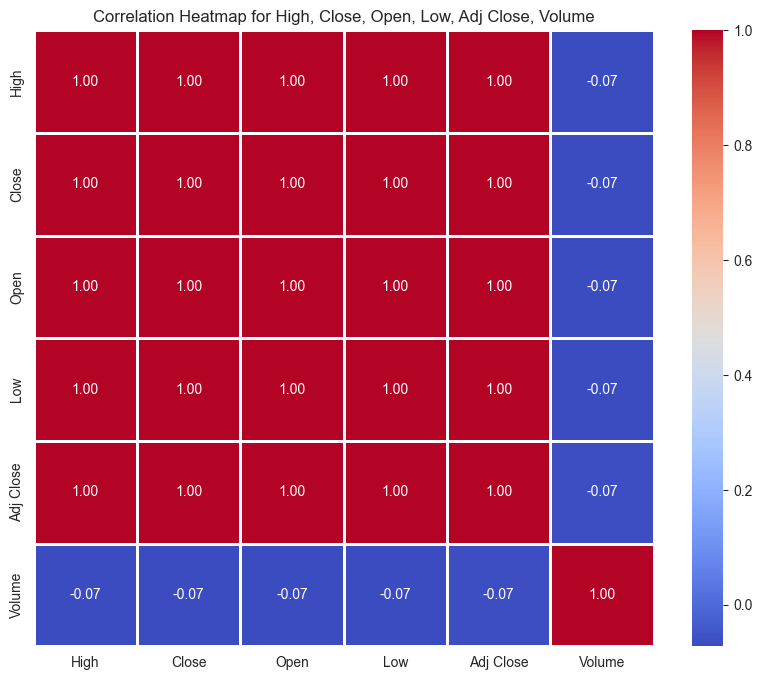

In [13]:
correlation_data = data[['High', 'Close', 'Open', 'Low', 'Adj Close', 'Volume']]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('Correlation Heatmap for High, Close, Open, Low, Adj Close, Volume')
plt.show()

Box plots for all numerical features of selected stocks. These plots give us an insight in distribution of each feature of a few selected stocks.

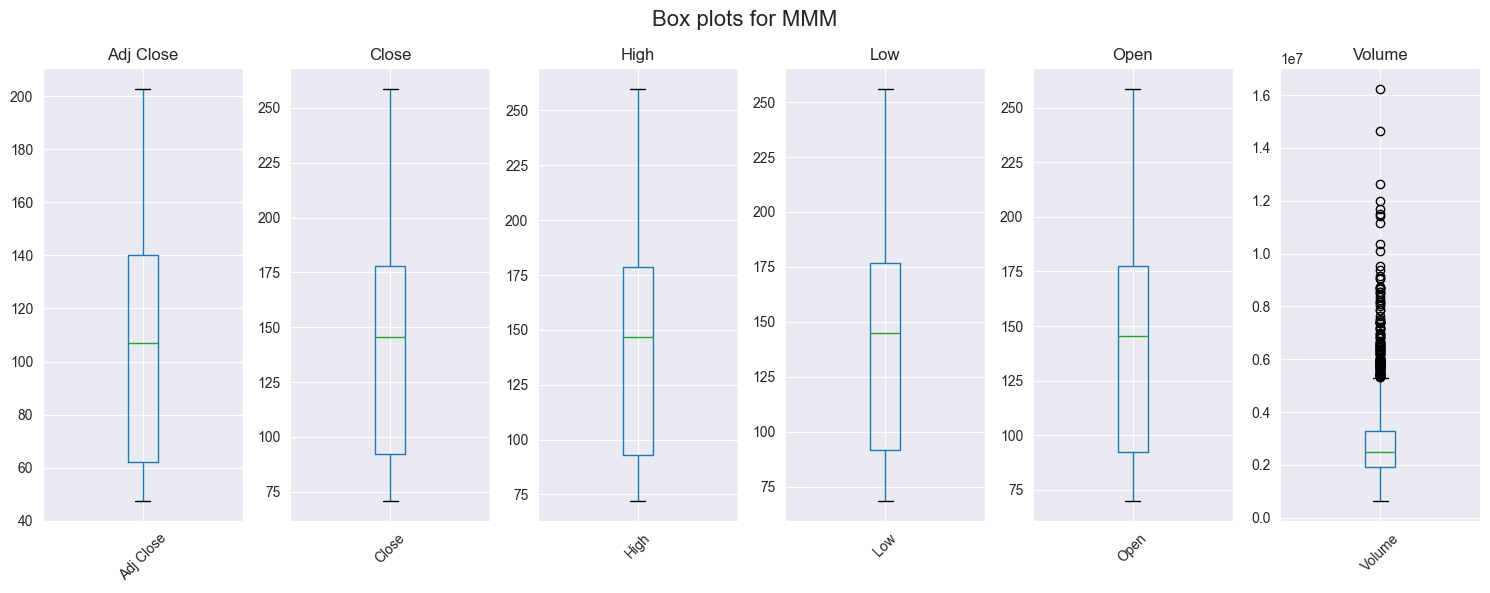

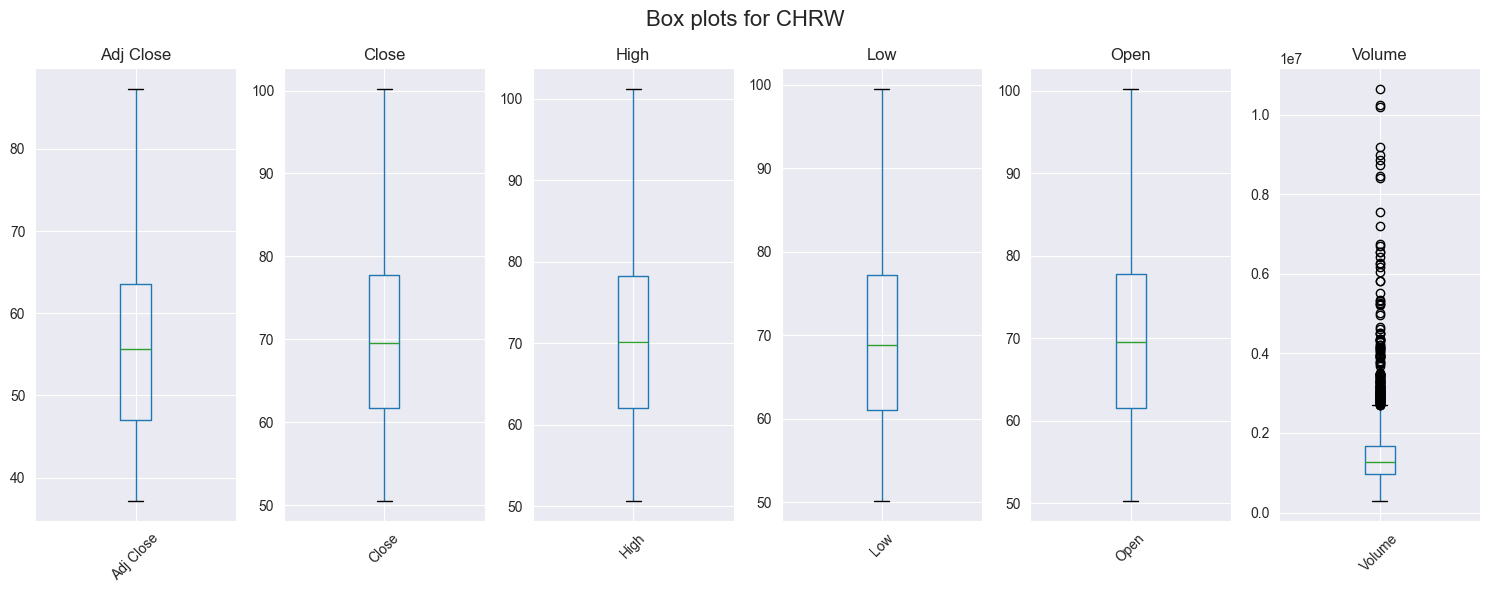

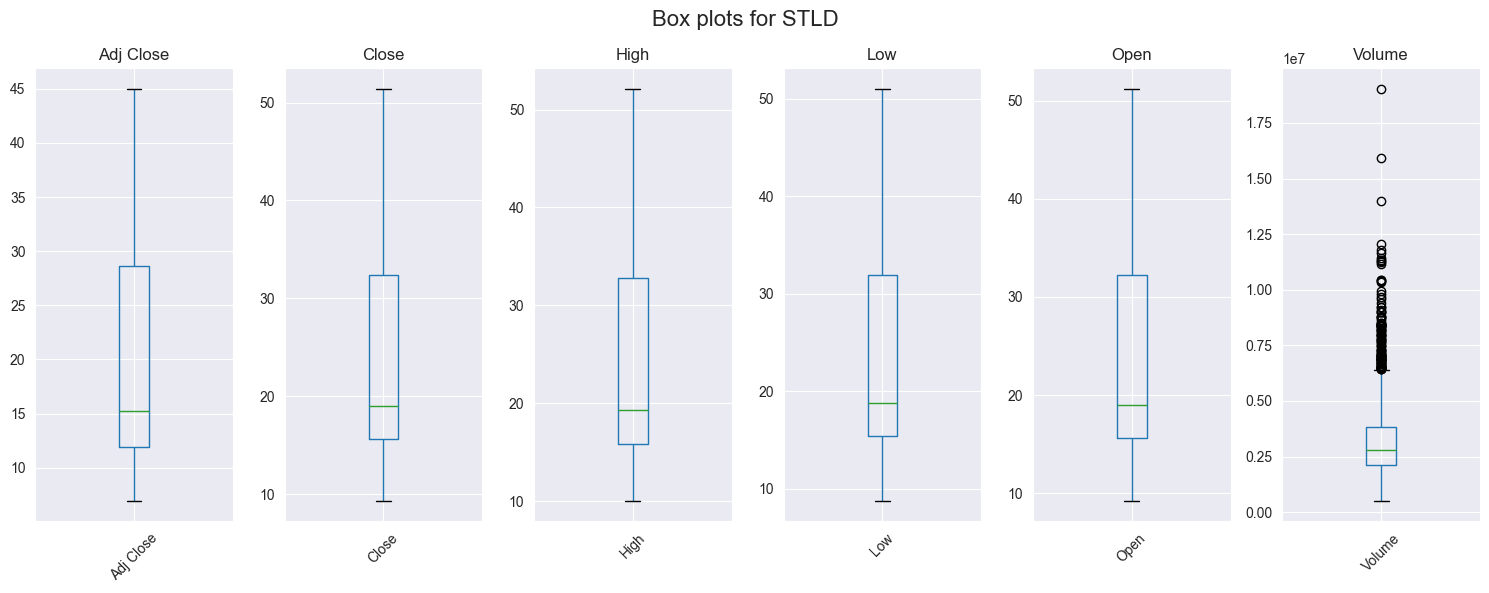

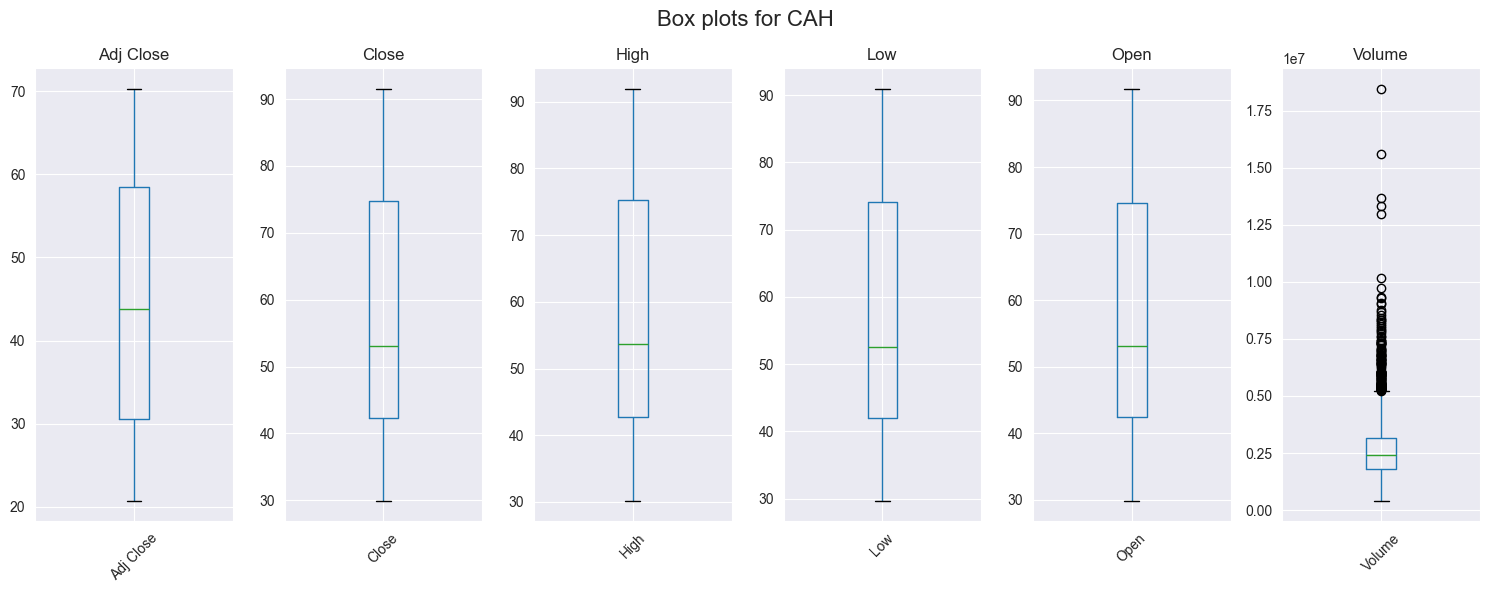

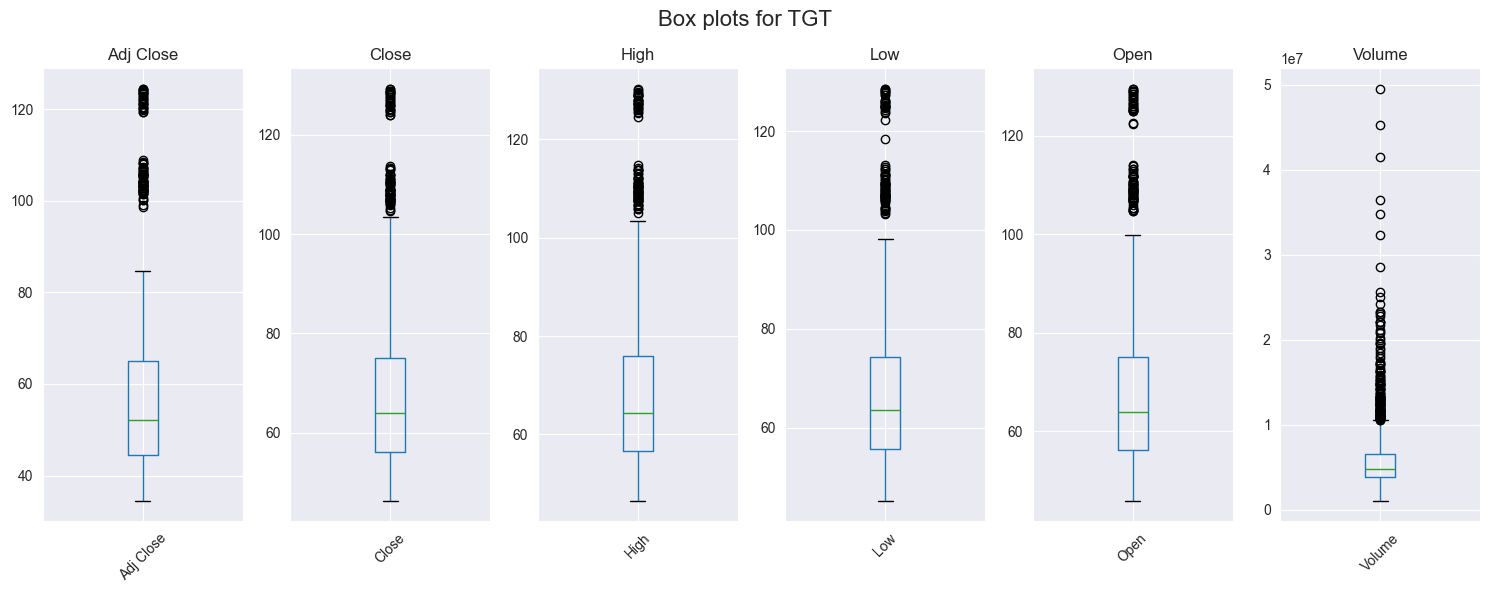

In [14]:
first_5_symbols = data['Symbol'].unique()[:5]
data_subset = data[data['Symbol'].isin(first_5_symbols)]

numerical_features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

for symbol in first_5_symbols:
    plt.figure(figsize=(15, 6))
    plt.suptitle(f'Box plots for {symbol}', fontsize=16)

    subset = data_subset[data_subset['Symbol'] == symbol]

    for i, feature in enumerate(numerical_features, start=1):
        plt.subplot(1, len(numerical_features), i)
        plt.title(feature)
        subset.boxplot(column=feature)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

Histograms of numeric features for five selected stocks.

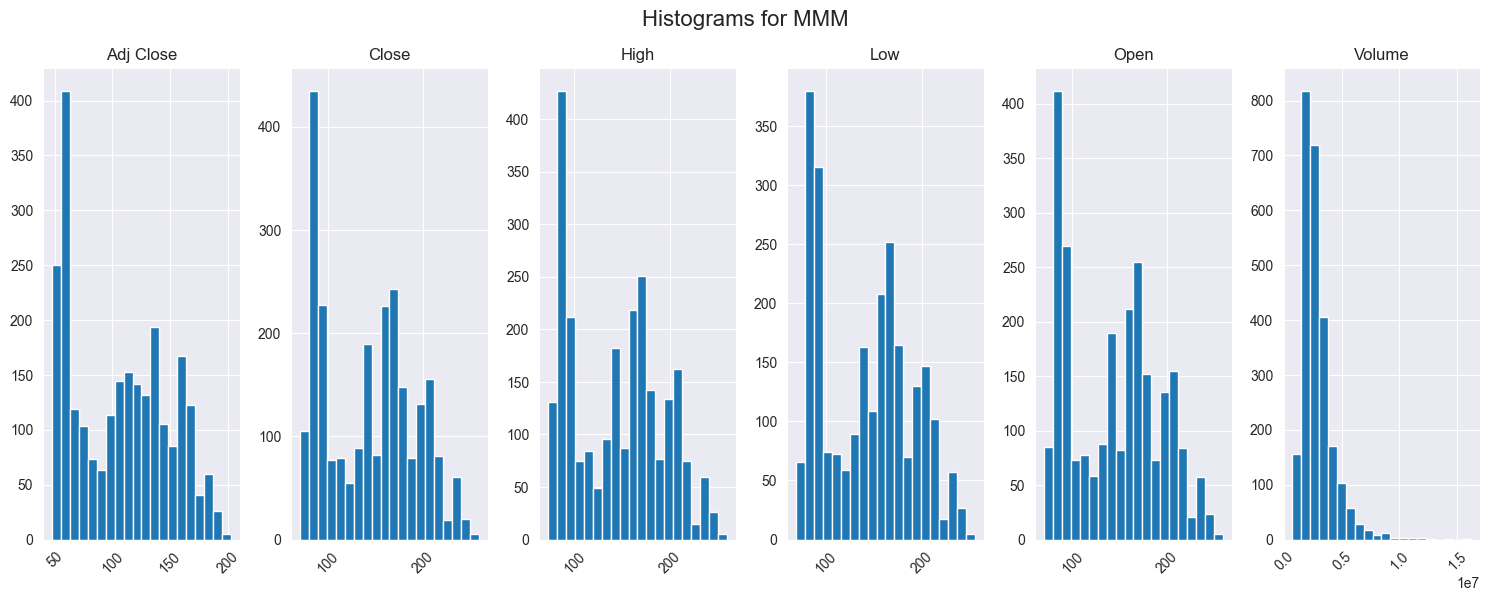

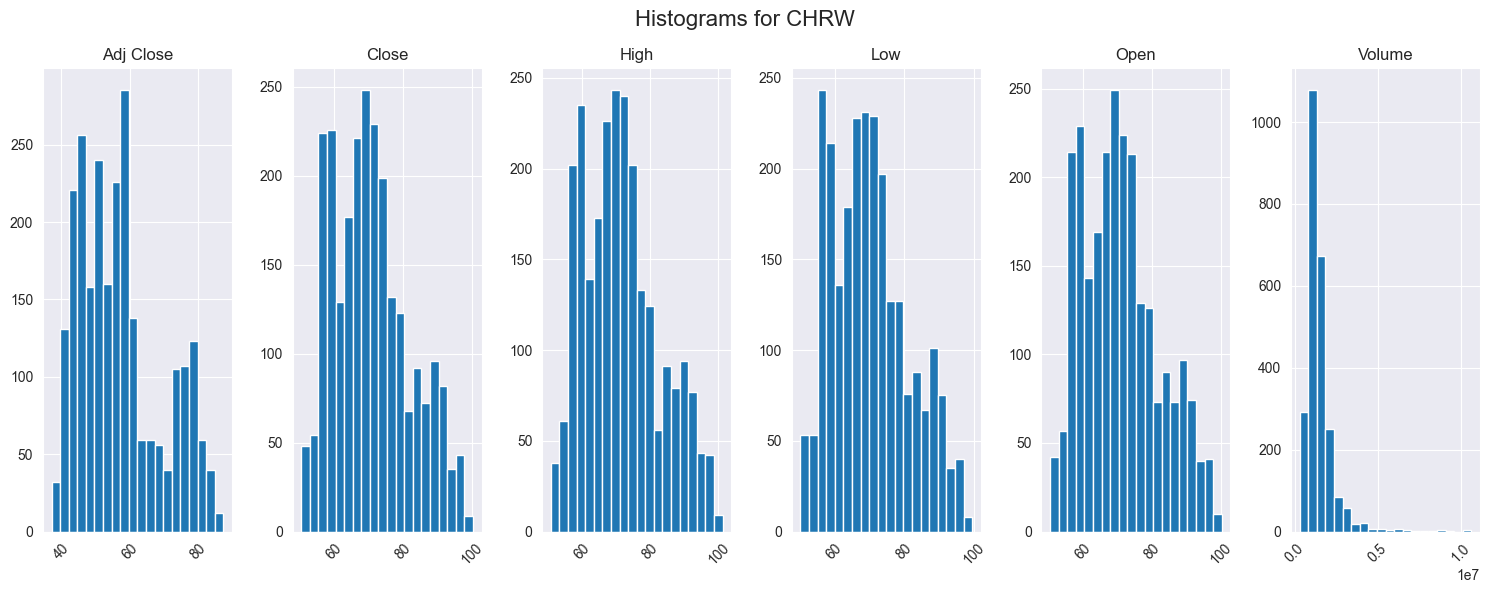

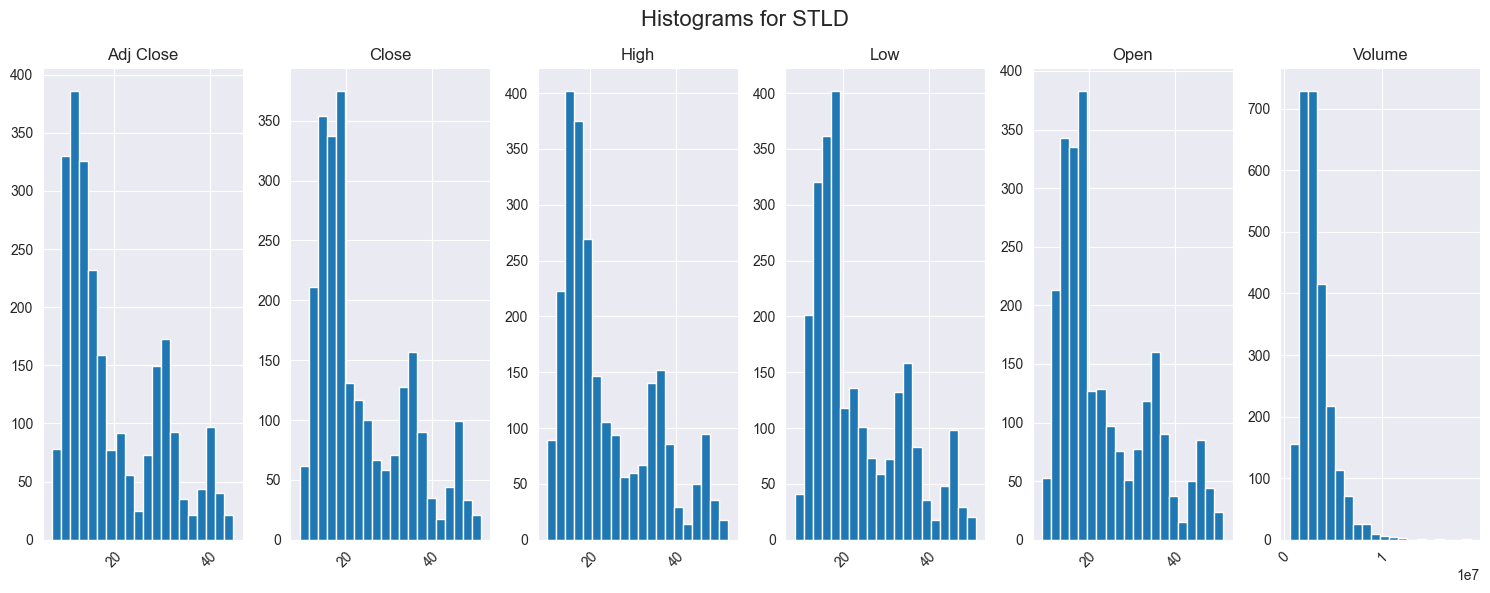

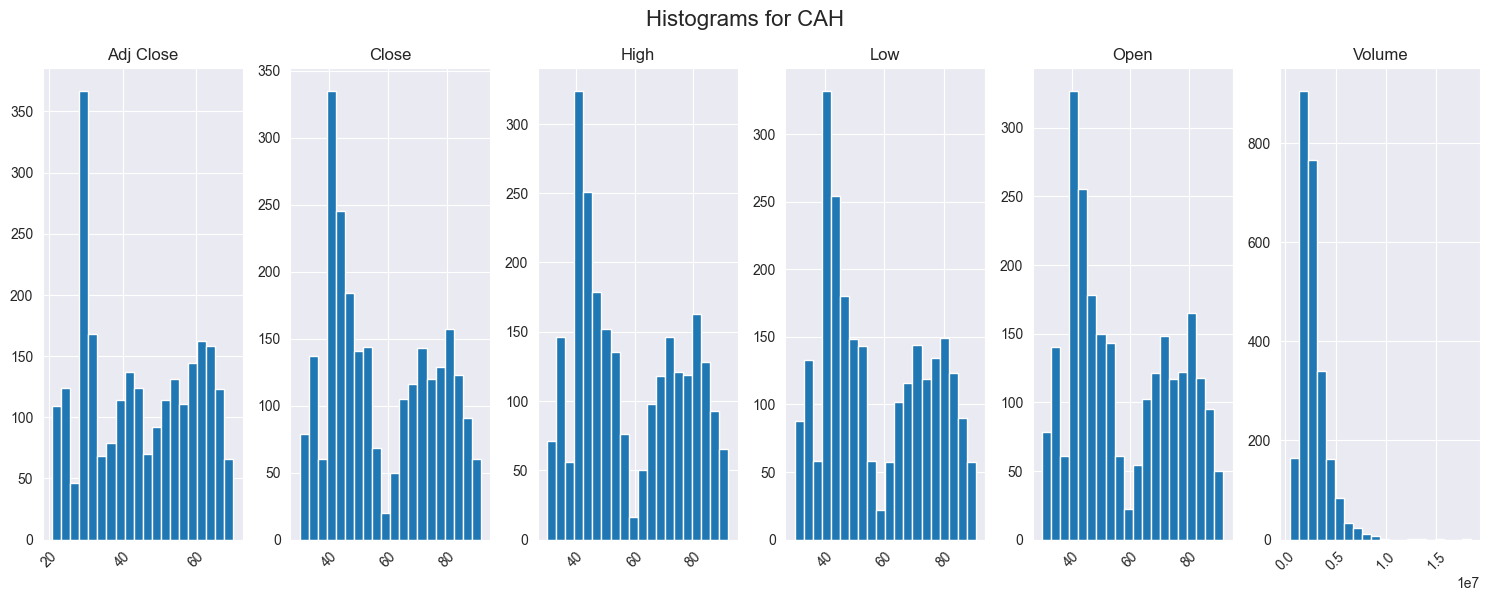

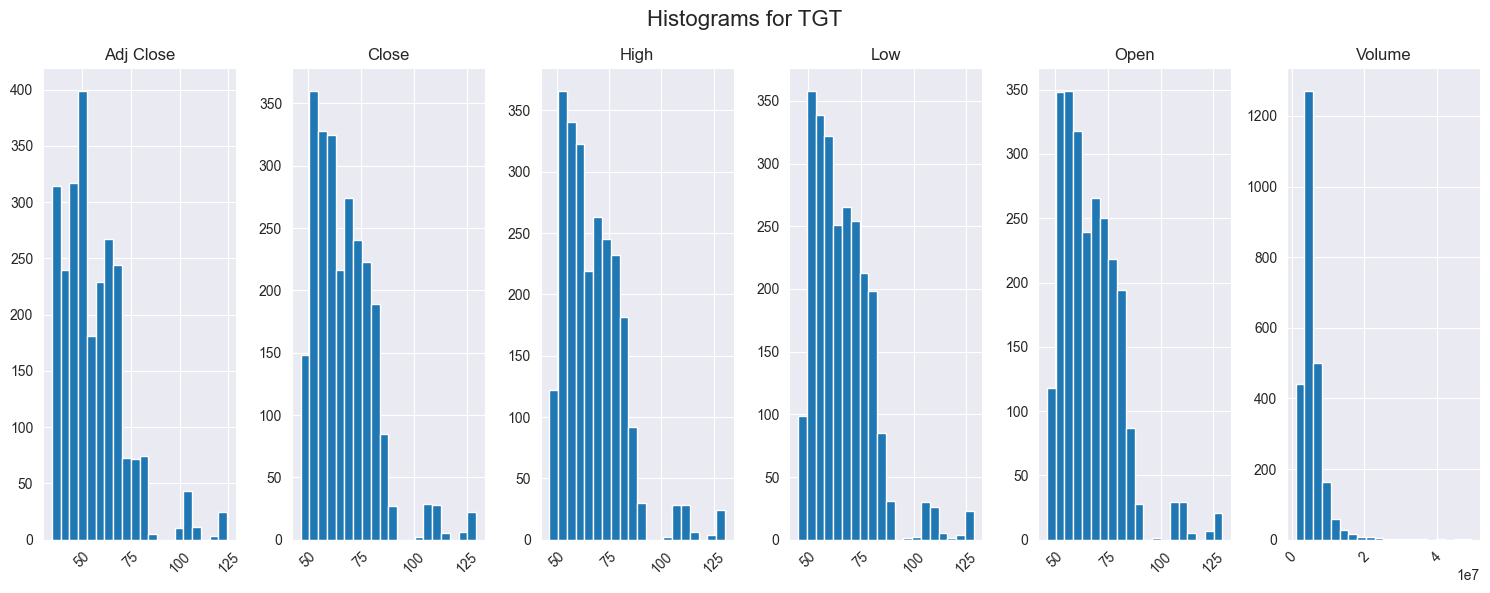

In [15]:
for symbol in first_5_symbols:
    plt.figure(figsize=(15, 6))
    plt.suptitle(f'Histograms for {symbol}', fontsize=16)

    subset = data_subset[data_subset['Symbol'] == symbol]

    for i, feature in enumerate(numerical_features, start=1):
        plt.subplot(1, len(numerical_features), i)
        plt.title(feature)
        plt.hist(subset[feature], bins=20)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

Violin plots...

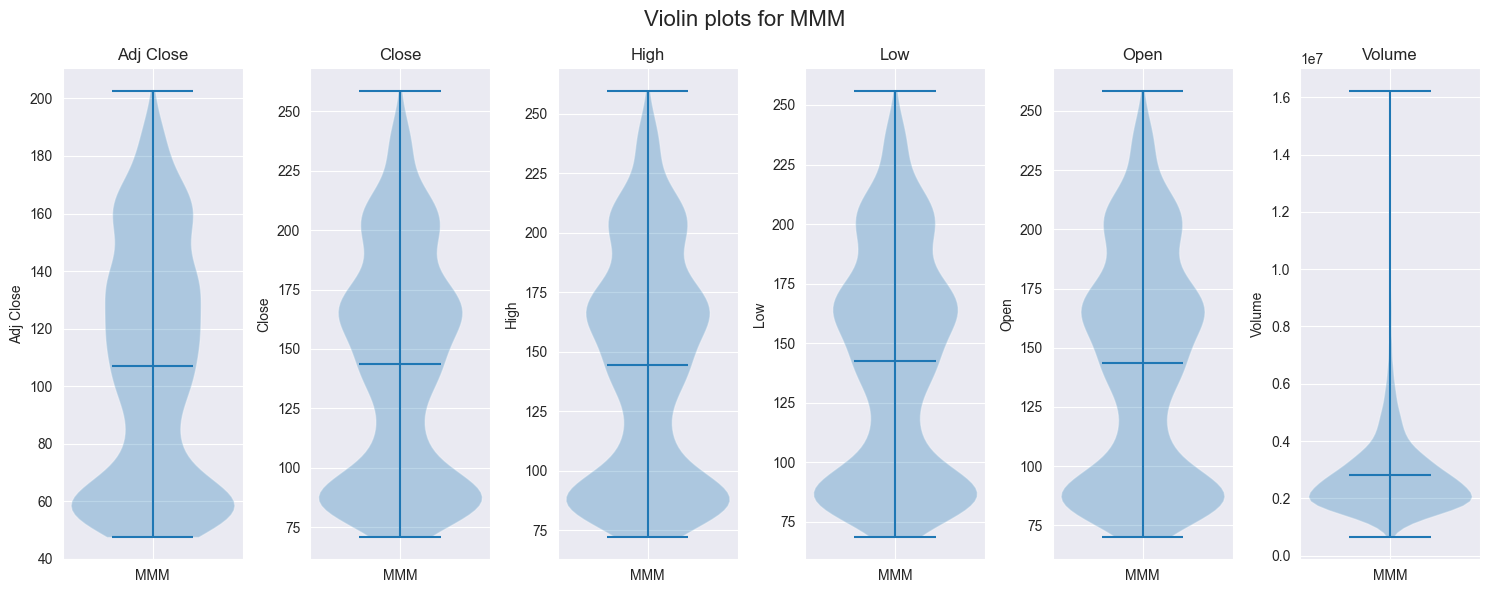

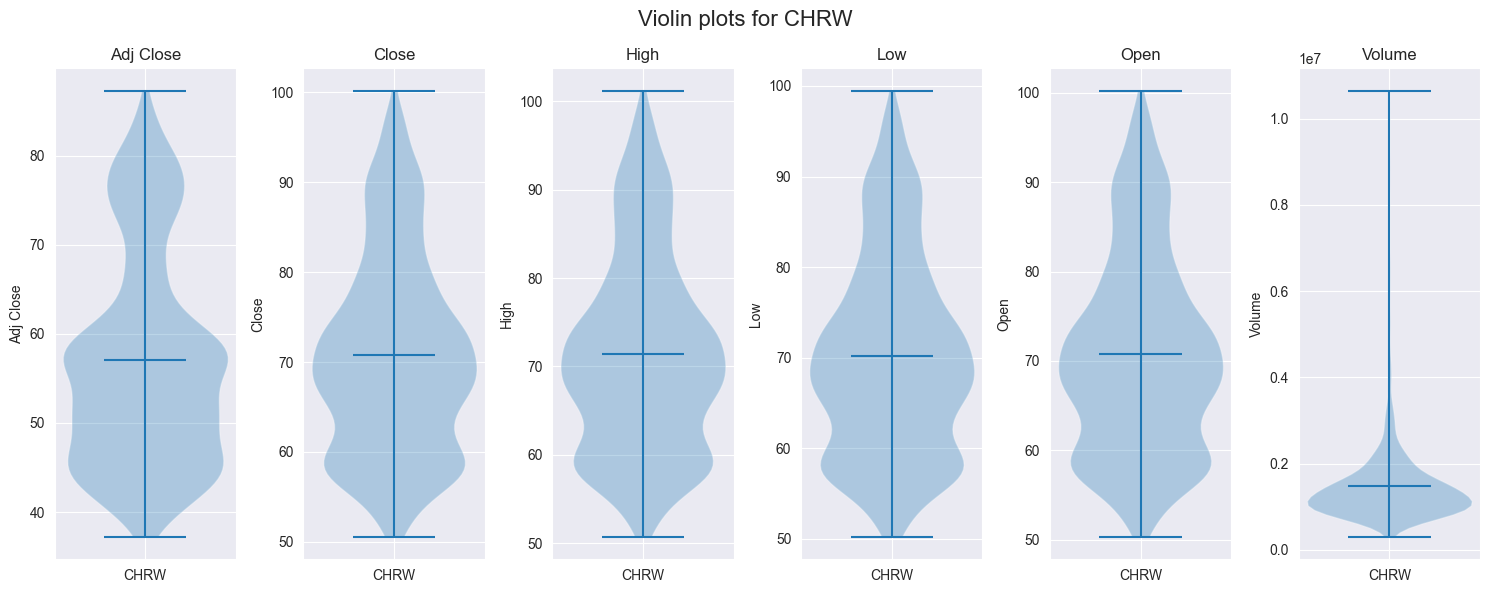

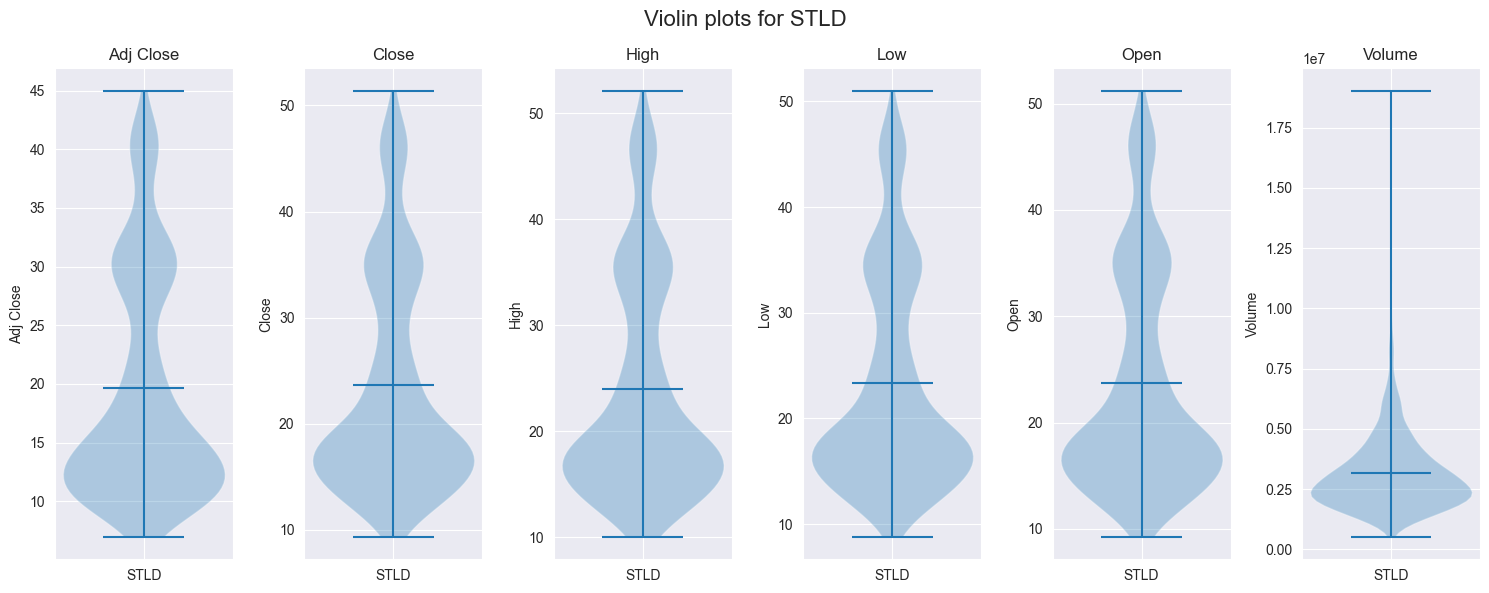

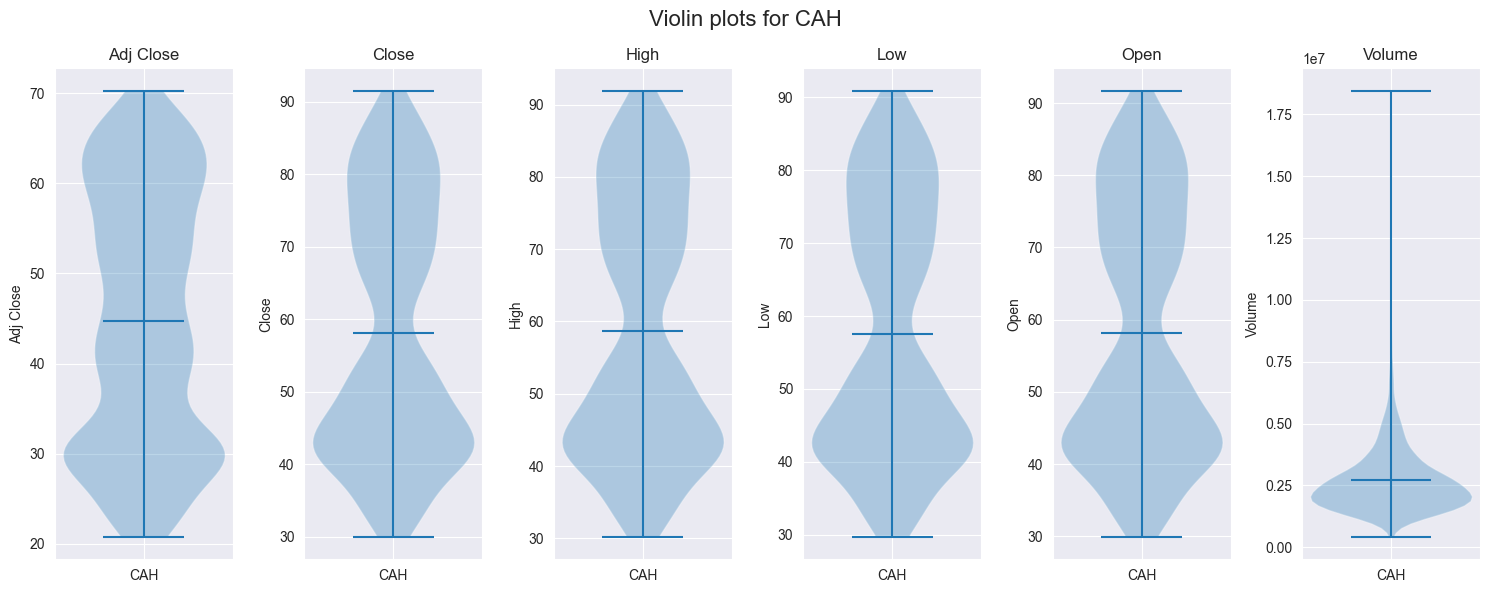

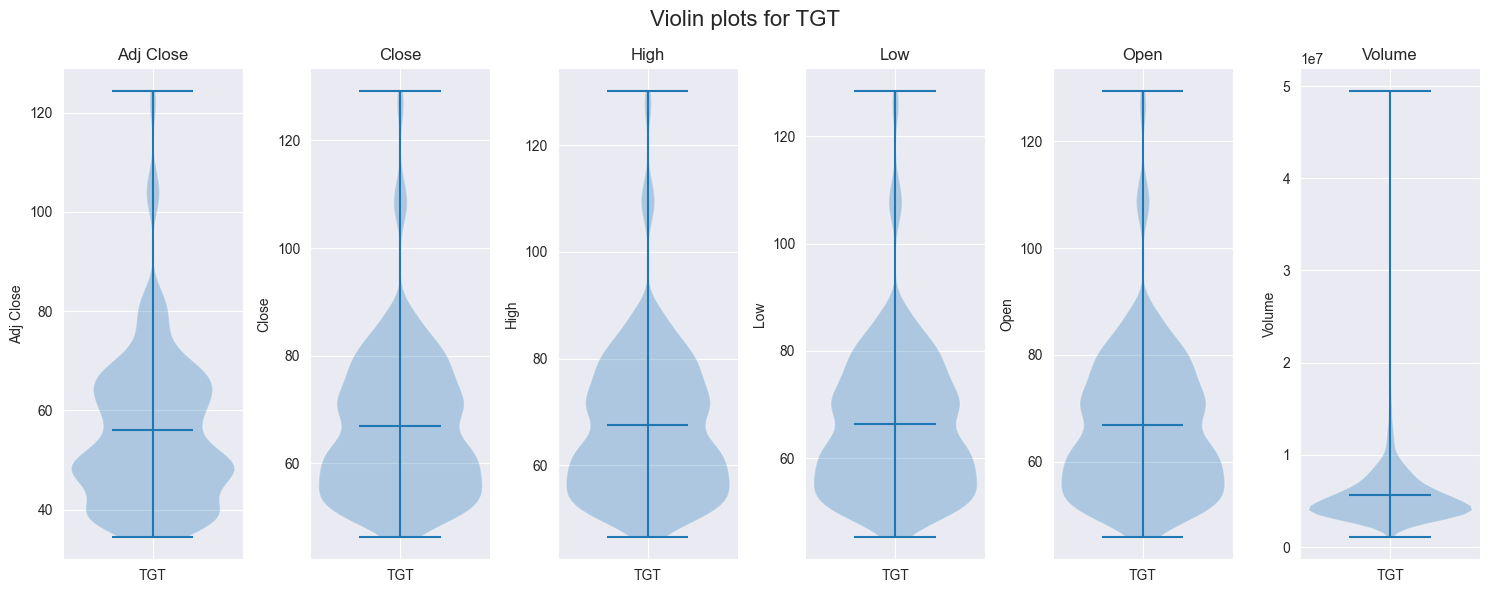

In [16]:
for symbol in first_5_symbols:
    plt.figure(figsize=(15, 6))
    plt.suptitle(f'Violin plots for {symbol}', fontsize=16)
    
    subset = data_subset[data_subset['Symbol'] == symbol]
    
    for i, feature in enumerate(numerical_features, start=1):
        plt.subplot(1, len(numerical_features), i)
        plt.title(feature)
        plt.violinplot(subset[feature], showmeans=True)
        plt.xticks([1], [symbol])
        plt.ylabel(feature)
        
    plt.tight_layout()
    plt.show()

Training dataset distribution by target feature for the first four stocks.

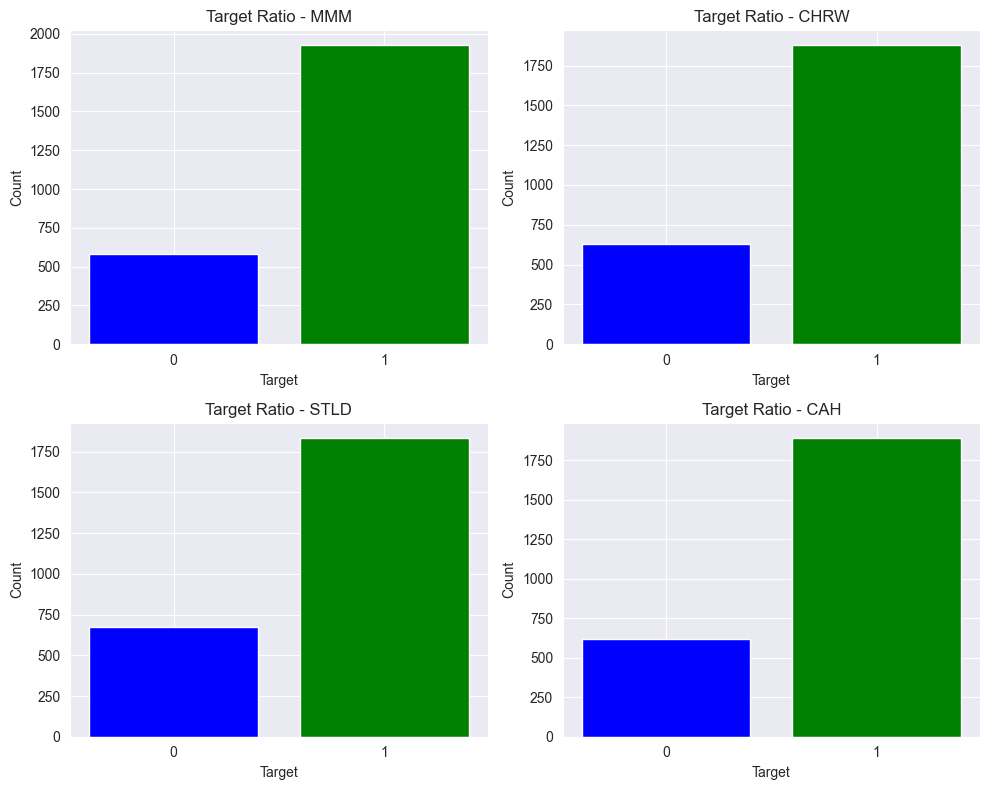

In [17]:
symbol_counts = data['Symbol'].unique()[:4]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, symbol in enumerate(symbol_counts):
    row = i // 2
    col = i % 2

    symbol_data = data[data['Symbol'] == symbol]
    target_counts = symbol_data['Target'].value_counts().sort_index()

    axs[row, col].bar(target_counts.index.astype(str), target_counts.values, color=['b', 'g'])
    axs[row, col].set_title(f'Target Ratio - {symbol}')
    axs[row, col].set_xlabel('Target')
    axs[row, col].set_ylabel('Count')

plt.tight_layout()
plt.show()


Line chart of High, Low, Open and Close feature movement over time for a selected stock.

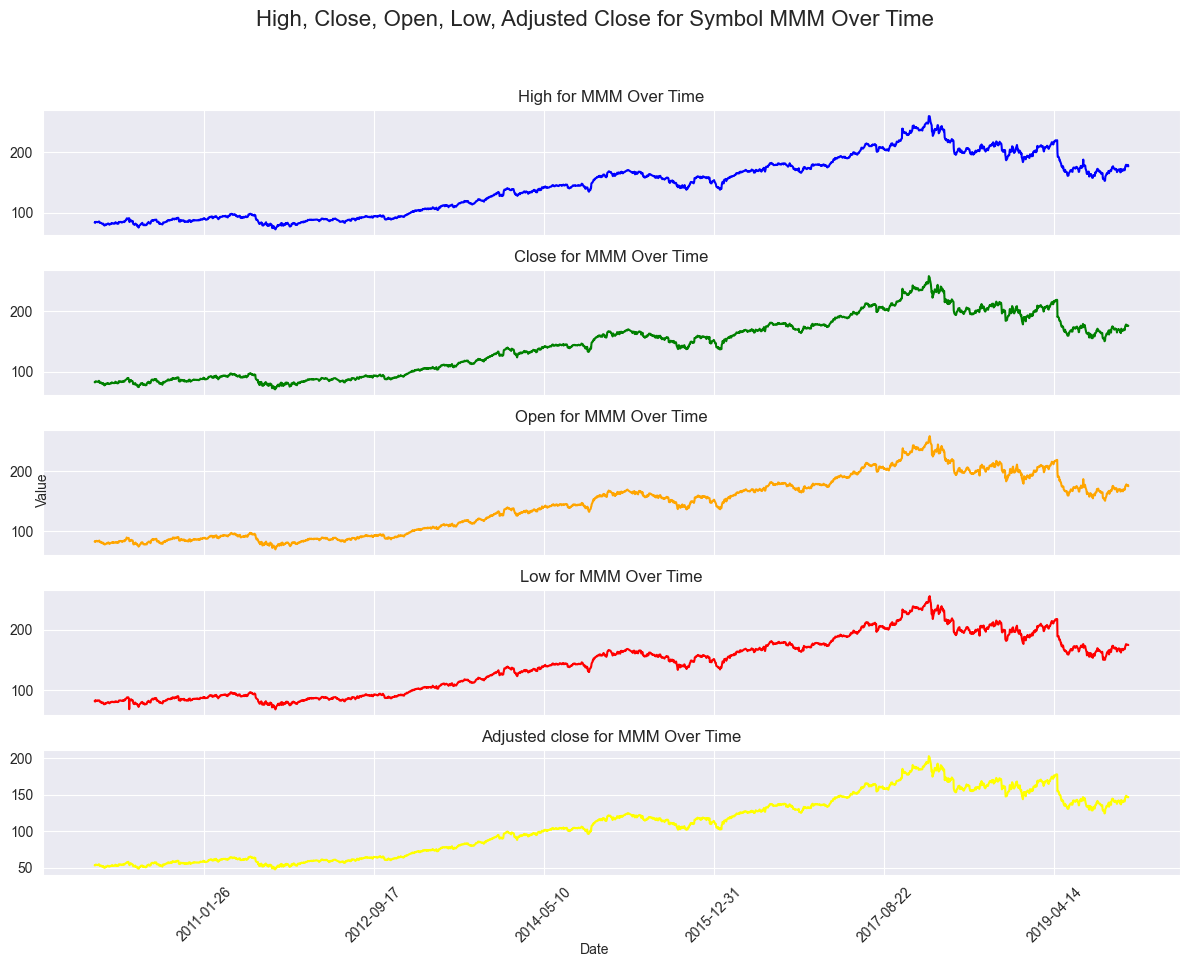

In [18]:
mmm_data = data[data['Symbol'] == 'MMM'].copy()

fig, axs = plt.subplots(nrows=5, figsize=(12, 10), sharex=True)

axs[0].plot(mmm_data['Date'], mmm_data['High'], label='High', color='blue')
axs[1].plot(mmm_data['Date'], mmm_data['Close'], label='Close', color='green')
axs[2].plot(mmm_data['Date'], mmm_data['Open'], label='Open', color='orange')
axs[3].plot(mmm_data['Date'], mmm_data['Low'], label='Low', color='red')
axs[4].plot(mmm_data['Date'], mmm_data['Adj Close'], label='Low', color='yellow')

axs[0].set_title('High for MMM Over Time')
axs[1].set_title('Close for MMM Over Time')
axs[2].set_title('Open for MMM Over Time')
axs[3].set_title('Low for MMM Over Time')
axs[4].set_title('Adjusted close for MMM Over Time')

fig.suptitle('High, Close, Open, Low, Adjusted Close for Symbol MMM Over Time', fontsize=16)
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.04, 0.5, 'Value', ha='center', va='center', rotation='vertical')

for ax in axs:
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=(0.0, 0.03, 1.0, 0.95))
plt.show()

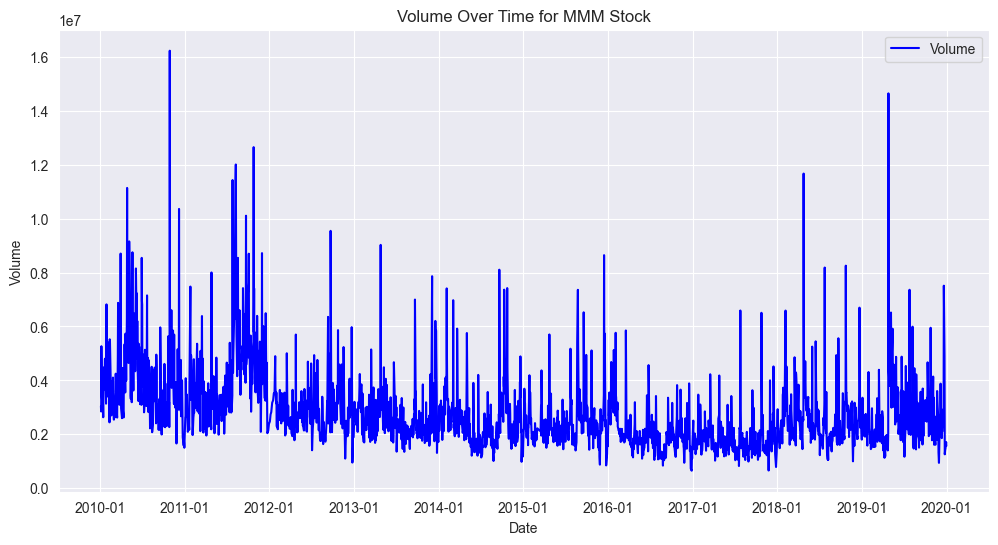

In [19]:
mmm_data.loc[:, 'Date'] = pd.to_datetime(mmm_data['Date'])

plt.figure(figsize=(12, 6))
plt.plot(mmm_data['Date'], mmm_data['Volume'], label='Volume', color='blue')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('Volume Over Time for MMM Stock')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

Scatter plots

Due to the strong correlation between features scatter plots will not be very useful mean of data visualization, however a selection of scatter plots is still included to demonstrate this claim.

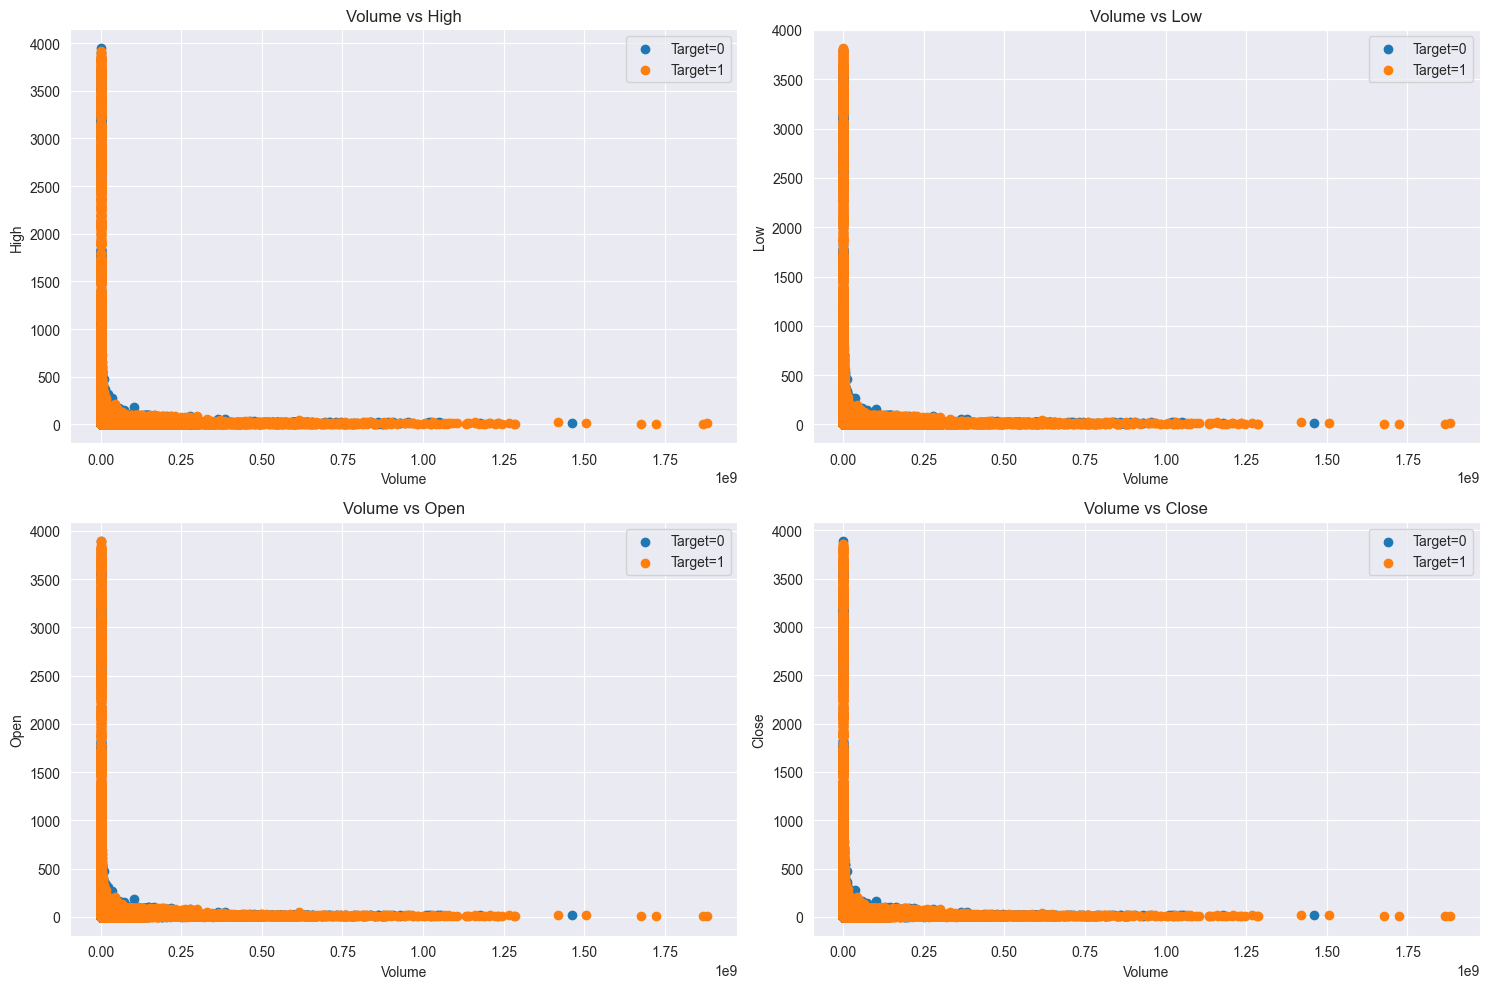

In [20]:
features = ['High', 'Low', 'Open', 'Close']
target_values = data['Target'].unique()

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)

    for target_value in target_values:
        subset_df = data[data['Target'] == target_value]
        plt.scatter(subset_df['Volume'], subset_df[feature], label=f'Target={target_value}')

    plt.title(f'Volume vs {feature}')
    plt.xlabel('Volume')
    plt.ylabel(feature)
    plt.legend()

plt.tight_layout()
plt.show()

## Best stock to buy on 15th of April 2017?

To answer this question, a subset of the dataset will be formed that contains only the data for the following two months after the starting date. Then the stock with maximal growth will be found based on the Adj Close column.
Since 15th of April 2017 was a Saturday, the date will be adjusted to Monday the 17th.

In [21]:
data['Date'] = pd.to_datetime(data['Date'])

filtered_data = data[data['Date'] >= '2017-04-17']

end_date = pd.to_datetime('2017-06-17')
filtered_data = filtered_data[filtered_data['Date'] <= end_date]

growth_data = filtered_data.groupby('Symbol').agg({
    'Adj Close': lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100
})

max_growth_stock = growth_data.idxmax().iloc[0]
max_growth_percentage = growth_data.max().iloc[0]

print(f"The stock with the biggest growth after April 17, 2017, is '{max_growth_stock}' with a growth of {max_growth_percentage:.2f}%.")

The stock with the biggest growth after April 17, 2017, is 'NVDA' with a growth of 52.96%.


## Baseline classifier
A few basic classifiers will be trained on the dataset with no feature engineering or hyperparameter tuning. This will provide a baseline for more complicated models better suited for time series data.

In [22]:
def train_classificator(X, y, classifier):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 0.7861549006168609
Confusion Matrix:
[[  621 20043]
 [  237 73934]]


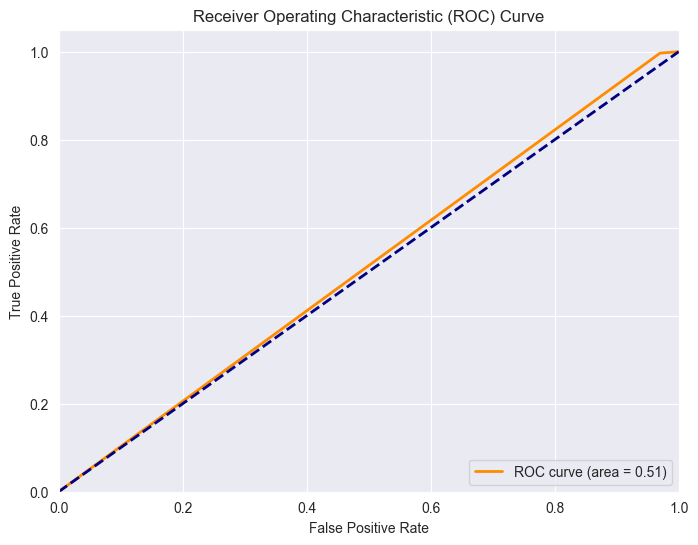

In [23]:
X = data.drop(columns=['Target', 'Date', 'Symbol', 'Id'])
y = data['Target']

xgb_classifier = xgb.XGBClassifier(random_state=42)
train_classificator(X, y, xgb_classifier)

Accuracy: 0.7406337322718406
Confusion Matrix:
[[ 1596 19068]
 [ 5529 68642]]


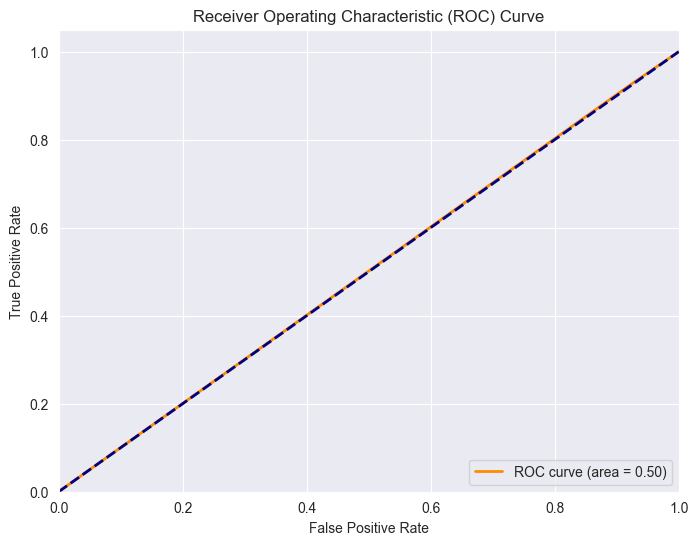

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
train_classificator(X, y, knn)

Accuracy: 0.7984604839985238
Confusion Matrix:
[[ 3845 16819]
 [ 2294 71877]]


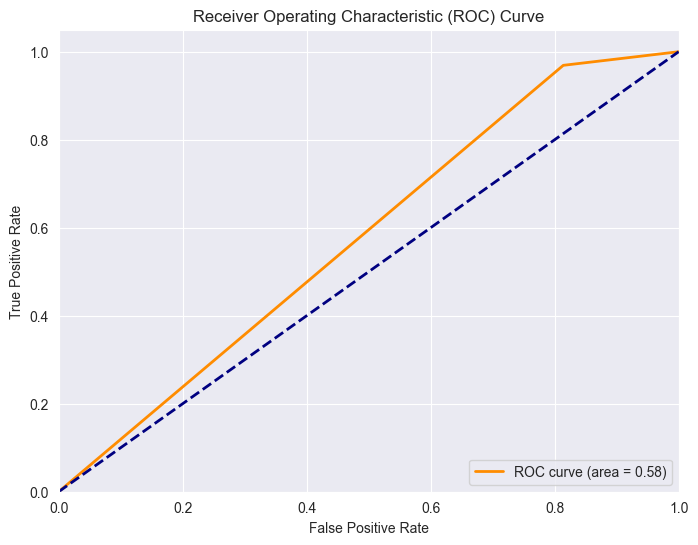

In [25]:
rfc = RandomForestClassifier()
train_classificator(X, y, rfc)

Accuracy: 0.7821057626403753
Confusion Matrix:
[[    0 20664]
 [    0 74171]]


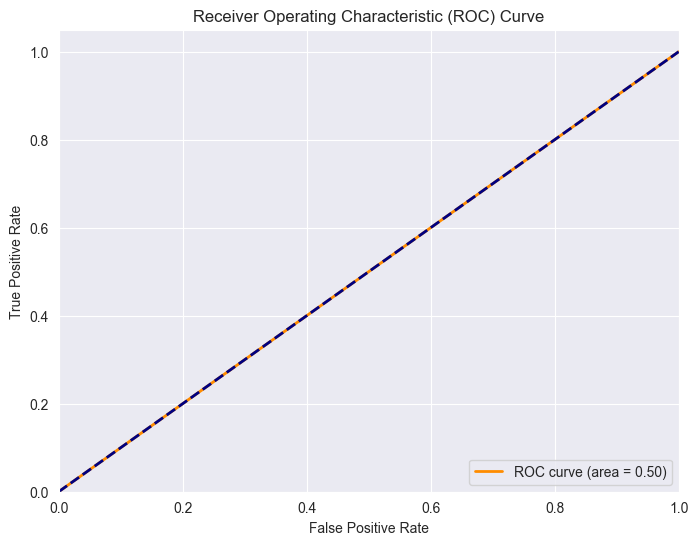

In [26]:
lrc = LogisticRegression()
train_classificator(X, y, lrc)

None of the tested classifiers performed good, but that was expected. Their performance is on par with a random 50-50 chance classifier. However, Random Forrest Classifier had the best performance, so it will be used to provide classification of the test data.

In [29]:
test_data = pd.read_csv('data/test.csv')
X = test_data.drop(columns=['Date', 'Symbol', 'Id'])

predictions = rfc.predict(X)

submission_df = pd.DataFrame({
    'Id': test_data['Id'],
    'Predicted': predictions
})

submission_df.to_csv('submission.csv', index=False)